In [ ]:
!pip install -q imbalanced-learn sastrawi tqdm
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import pandas as pd
import numpy as np
df = pd.read_csv('komentar1.csv')
df

,stopword_str,sentimen
0,jalan karya makmur rusak parah,negatif
1,densel,positif
2,kabel listrik tiang listrik canggu terimakasih,negatif
3,moga jalan denpasar bagus banjir,positif
4,jalan gunung andakasa gang mataharu padangsambian,negatif
...,...,...
85,selamat sore jalan lintas denpasar jalan troto...,positif
86,macet sampah punapi program,negatif
87,lantai bor,positif
88,kerja masyarakat,positif


In [ ]:
df.shape

(90, 2)

In [ ]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
negatif    53
positif    37
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df['text'] = df['text'].apply(clean_text)
df

,comment_id,created_at,profile_pic_url,text,user_id,username,sentimen
0,18127023118425232,1744885297,https://scontent-cgk2-1.cdninstagram.com/v/t51...,jalan karya makmur pak rusak parah,627070985,tan3.andriani,negatif
1,18042828905428306,1744891304,https://scontent-cgk1-2.cdninstagram.com/v/t51...,,741125731,pandai_belajar,positif
2,18370847881193728,1744891431,https://scontent-cgk1-2.cdninstagram.com/v/t51...,apakah memungkinkan tidak ada kabel listrik da...,741125731,pandai_belajar,negatif
3,18080302258708590,1744891543,https://scontent-cgk2-1.cdninstagram.com/v/t51...,semoga jalan2 di denpasar jadi bagus dan tidak...,20935136607,rahayu.adiputra,positif
4,17956344713929545,1744892232,https://scontent-cgk1-1.cdninstagram.com/v/t51...,jl gn andakasa gang mataharu kapan diperbaikin...,1833078665,toeayu,negatif
...,...,...,...,...,...,...,...
98,18052723655248645,1744884111,https://scontent-cgk2-2.cdninstagram.com/v/t51...,selamat sore untuk soal jalan dan lalu lintas ...,3026831124,mfebrian_8,positif
99,17982306734832336,1744884716,https://scontent-cgk1-2.cdninstagram.com/v/t51...,untuk kemacetan dan sampah punapi programnya pak,5465948511,mrjoebali,negatif
100,18088648459608289,1744859474,https://scontent-cgk2-1.cdninstagram.com/v/t51...,lantai 3 bor,343630950,ariapramanaa,positif
101,17929594338041478,1744859743,https://scontent-cgk2-1.cdninstagram.com/v/t51...,berkinerja untuk masyarakat,6271578941,purnamasaridewiratih,positif


In [ ]:
df_norm = df["text"]
df_norm
norm = {
    " akhir " : " akhirnya ",
    " nhaah " : " nah ",
    " jalan2 " : " jalan-jalan ",
    " jl " : " jalan ",
    " gn " : " gunung ",
    " & " : " dan ",
    " anggarannyakah " : " ada anggarannya tidak ",
    " dpt " : " dapat ",
    " utk " : " untuk ",
    " cenik " : " kecil ",
    " bedik " : " sedikit ",
    " ngemang " : " memberikan ",
    " kykne " : " sepertinya ",
    " sihh " : " sih ",
    " keto " : " begitu ",
    " kk " : " kak ",
    " yg " : " yang ",
    " ruas2 " : " ruas-ruas ",
    " p " : " pak ",
    " tsb " : " tersebut ",
    " astungkara " : " semoga ",
    " mhn " : " mohon ",
    " tdk " : " tidak ",
    " naek " : " naik ",
    " spt " : " seperti ",
    " rollcoaster " : " rollercoster ",
    " kalao " : " kalau ",
    " paking " : " paling ",
    " masib " : " masih ",
    " jln " : " jalan ",
    " kec.denpasar " : " kecamatan denpasar ",
    " / " : " atau ",
    " tida " : " tidak ",
    " nhaah " : " nah ",
    " smg " : " semoga ",
    " subak2 " : " subak-subak ",
    " jg " : " juga ",
    " mendpt " : " mendapat ",
    " saluran2 " : " saluran-saluran ",
    " tdk " : " tidak ",
    " mgkn " : " mungkin ",
    " pemkot " : " pemerintah kota ",
    " tp " : " tapi ",
    " ngga " : " tidak ",
    " bs " : " bisa ",
    " ngrus " : " mengurusi ",
    " sy " : " saya ",
    " krn " : " karena ",
    " nike " : " itu ",
    " th " : " tahun ",
    " rev " : " revisi ",
    " disampaika " : " disampaikan ",
    " dgn " : " dengan ",
    " dps " : " denpasar ",
    " karna " : " karena ",
    " teukumar " : " teuku umar ",
    " ngrus " : " mengurus ",
    " klo " : " kalau ",
    " napi " : " apa ",
    " krn " : " karena ",
    " barunkemarin " : " baru kemarin ",
    " diperbaik " : " diperbaiki ",
    " kira2 " : " kira-kira ",
    " diperbaik " : " diperbaiki ",
    " tsb " : " tersebut ",
    " ramp " : " rampung ",
    " yah " : " ya ",
    " y " : " ya ",
    " asal2an " : " asal-asalan ",
    " gak " : " tidak ", " ga " : " tidak ",
    " ramp " : " rampung ",
    " lubang2 " : " lubang-lubang ",
    " benyah " : " rusak ",
    " latig " : " parah ",
    " udh " : " sudah ",
    " brp " : " berapa ",
    " penambalab " : " penambalan ",
    " kalo " : " kalau ",
    " bs " : " bisa ",
    " menhakibatkankan " : " mengakibatkan ",
    " bgt " : " sekali ",
    " cuman " : " hanya ",
    " si " : " tidak ",
    " karna " : " karena ",
    " loh " : " lho ",
    " plisss " : " tolong ",
    " ex.wisata " : " mantan wisata ",
    " badah " : " waduh ",
    " jala " : " jalan ",
    " nggak " : " tidak ",
    " suksma " : " terimakasih ",
    " punapi " : " bagaimana ",
    " menhakibatkankan " : " mengakibatkan ",
}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df["text"] = df["text"].apply(normalisasi)
df

,comment_id,created_at,profile_pic_url,text,user_id,username,sentimen
0,18127023118425232,1744885297,https://scontent-cgk2-1.cdninstagram.com/v/t51...,jalan karya makmur pak rusak parah,627070985,tan3.andriani,negatif
1,18042828905428306,1744891304,https://scontent-cgk1-2.cdninstagram.com/v/t51...,,741125731,pandai_belajar,positif
2,18370847881193728,1744891431,https://scontent-cgk1-2.cdninstagram.com/v/t51...,apakah memungkinkan tidak ada kabel listrik da...,741125731,pandai_belajar,negatif
3,18080302258708590,1744891543,https://scontent-cgk2-1.cdninstagram.com/v/t51...,semoga jalan-jalan di denpasar jadi bagus dan ...,20935136607,rahayu.adiputra,positif
4,17956344713929545,1744892232,https://scontent-cgk1-1.cdninstagram.com/v/t51...,jl gunung andakasa gang mataharu kapan diperba...,1833078665,toeayu,negatif
...,...,...,...,...,...,...,...
98,18052723655248645,1744884111,https://scontent-cgk2-2.cdninstagram.com/v/t51...,selamat sore untuk soal jalan dan lalu lintas ...,3026831124,mfebrian_8,positif
99,17982306734832336,1744884716,https://scontent-cgk1-2.cdninstagram.com/v/t51...,untuk kemacetan dan sampah bagaimana programny...,5465948511,mrjoebali,negatif
100,18088648459608289,1744859474,https://scontent-cgk2-1.cdninstagram.com/v/t51...,lantai 3 bor,343630950,ariapramanaa,positif
101,17929594338041478,1744859743,https://scontent-cgk2-1.cdninstagram.com/v/t51...,berkinerja untuk masyarakat,6271578941,purnamasaridewiratih,positif


In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stop_remover = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stop_remover.remove(text)

df["text"] = df["text"].apply(remove_stopwords)

In [ ]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
negatif    53
positif    37
Name: count, dtype: int64


In [ ]:
tokenized = df["text"].apply(lambda x: x.split())
tokenized

,text
0,"[jalan, karya, makmur, pak, rusak, parah]"
1,[]
2,"[memungkinkan, ada, kabel, listrik, tiang, lis..."
3,"[semoga, jalan-jalan, denpasar, jadi, bagus, t..."
4,"[jl, gunung, andakasa, gang, mataharu, kapan, ..."
...,...
98,"[selamat, sore, soal, jalan, lalu, lintas, den..."
99,"[kemacetan, sampah, bagaimana, programnya, pak]"
100,"[lantai, 3, bor]"
101,"[berkinerja, masyarakat]"


In [ ]:
!pip install sastrawi tqdm
import pandas as pd
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tqdm.notebook import tqdm
tqdm.pandas()

stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df["text"] = df["text"].progress_apply(stemming)
df

  0%|          | 0/103 [00:00<?, ?it/s]

,comment_id,created_at,profile_pic_url,text,user_id,username,sentimen
0,18127023118425232,1744885297,https://scontent-cgk2-1.cdninstagram.com/v/t51...,jalan karya makmur pak rusak parah,627070985,tan3.andriani,negatif
1,18042828905428306,1744891304,https://scontent-cgk1-2.cdninstagram.com/v/t51...,,741125731,pandai_belajar,positif
2,18370847881193728,1744891431,https://scontent-cgk1-2.cdninstagram.com/v/t51...,mungkin ada kabel listrik tiang listrik di can...,741125731,pandai_belajar,negatif
3,18080302258708590,1744891543,https://scontent-cgk2-1.cdninstagram.com/v/t51...,moga jalan denpasar jadi bagus tidak banjir,20935136607,rahayu.adiputra,positif
4,17956344713929545,1744892232,https://scontent-cgk1-1.cdninstagram.com/v/t51...,jl gunung andakasa gang mataharu kapan baik pa...,1833078665,toeayu,negatif
...,...,...,...,...,...,...,...
98,18052723655248645,1744884111,https://scontent-cgk2-2.cdninstagram.com/v/t51...,selamat sore soal jalan lalu lintas denpasar b...,3026831124,mfebrian_8,positif
99,17982306734832336,1744884716,https://scontent-cgk1-2.cdninstagram.com/v/t51...,macet sampah bagaimana program pak,5465948511,mrjoebali,negatif
100,18088648459608289,1744859474,https://scontent-cgk2-1.cdninstagram.com/v/t51...,lantai 3 bor,343630950,ariapramanaa,positif
101,17929594338041478,1744859743,https://scontent-cgk2-1.cdninstagram.com/v/t51...,kerja masyarakat,6271578941,purnamasaridewiratih,positif


In [ ]:
df = df.dropna(subset=['sentimen'])
df = df[df['stopword_str'].str.strip() != '']
teks_komentar = df[['stopword_str', 'sentimen']]

In [ ]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:


NameError: name 'df' is not defined

Jumlah data per kelas sentimen:
sentimen
positif    53
negatif    53
Name: count, dtype: int64


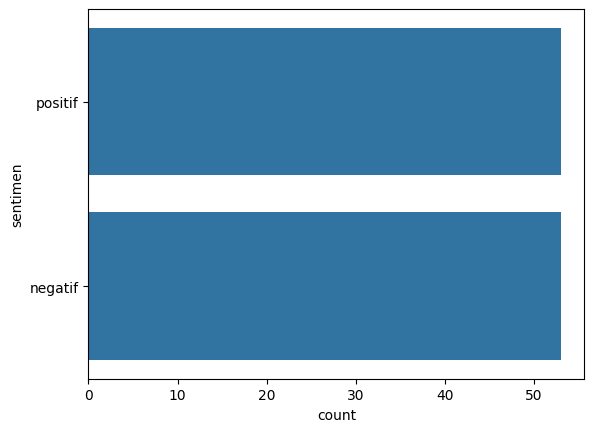

In [ ]:
def balance_data(df, label_col):
    max_count = df[label_col].value_counts().max()
    balanced_df = pd.concat([
        resample(df[df[label_col] == cls], replace=True, n_samples=max_count, random_state=42)
        for cls in df[label_col].unique()
    ])
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

df = balance_data(df, 'sentimen')

import seaborn as sns
sns.countplot(df['sentimen'])
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

In [ ]:
X = df['stopword_str']
y = df['sentimen']

X_train_text, X_test_text, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print(X_train.shape[1])

345


In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

In [ ]:
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 100}
Akurasi: 0.91

Classification Report:
               precision    recall  f1-score   support

     negatif       0.91      0.91      0.91        11
     positif       0.91      0.91      0.91        11

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22



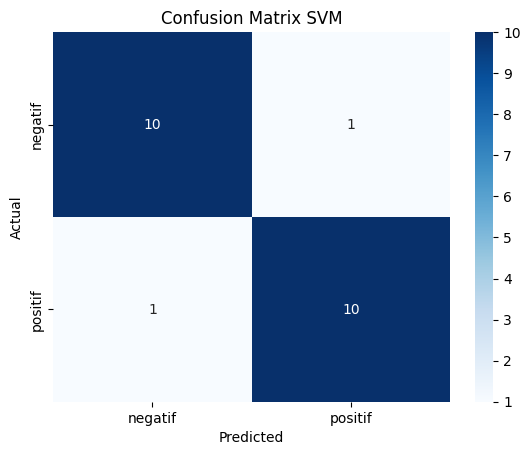

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
svm = LinearSVC(max_iter=10000)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Ambil model terbaik
best_svm = grid_search.best_estimator_

y_pred = best_svm.predict(X_test)

print("Akurasi:", round(accuracy_score(y_test, y_pred), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Optional: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix SVM')
plt.show()

In [ ]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_train.sum(axis=0).A1

top_words_df = pd.DataFrame({
    'Kata': feature_names,
    'Skor_TFIDF': tfidf_sum
}).sort_values(by='Skor_TFIDF', ascending=False)

print(top_words_df.head(20))

             Kata  Skor_TFIDF
108         jalan    8.419128
68       denpasar    4.192709
182    masyarakat    2.998252
31         banjir    2.932045
324        tolong    2.813494
196          moga    2.596351
270         rusak    2.584848
135         kerja    2.572043
23          bagus    2.547710
330         tukad    2.309476
69   denpasarkota    2.295143
16          aspal    2.194482
169         lurah    2.115796
327       trotoar    2.103024
167        lubang    2.067521
146          kota    2.025036
193           min    1.941855
272         salur    1.802943
197         mohon    1.697771
79           dung    1.697196


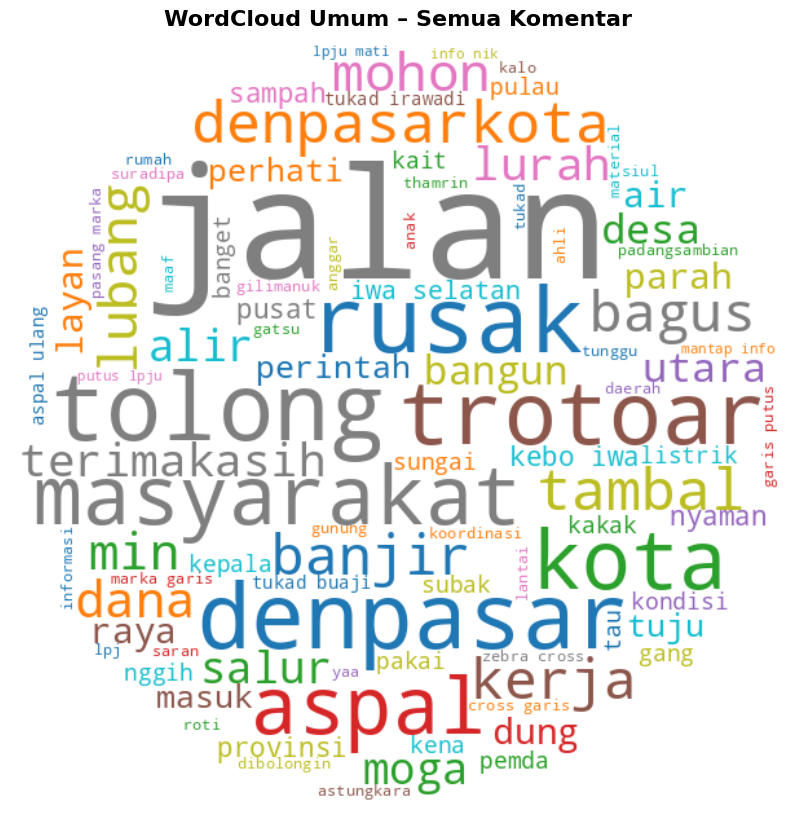

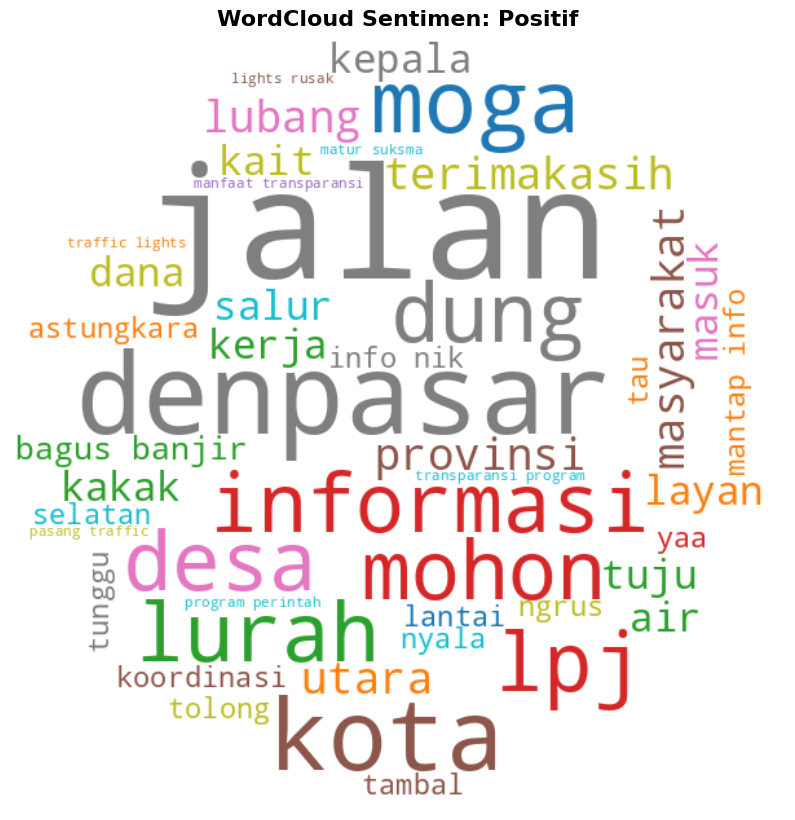

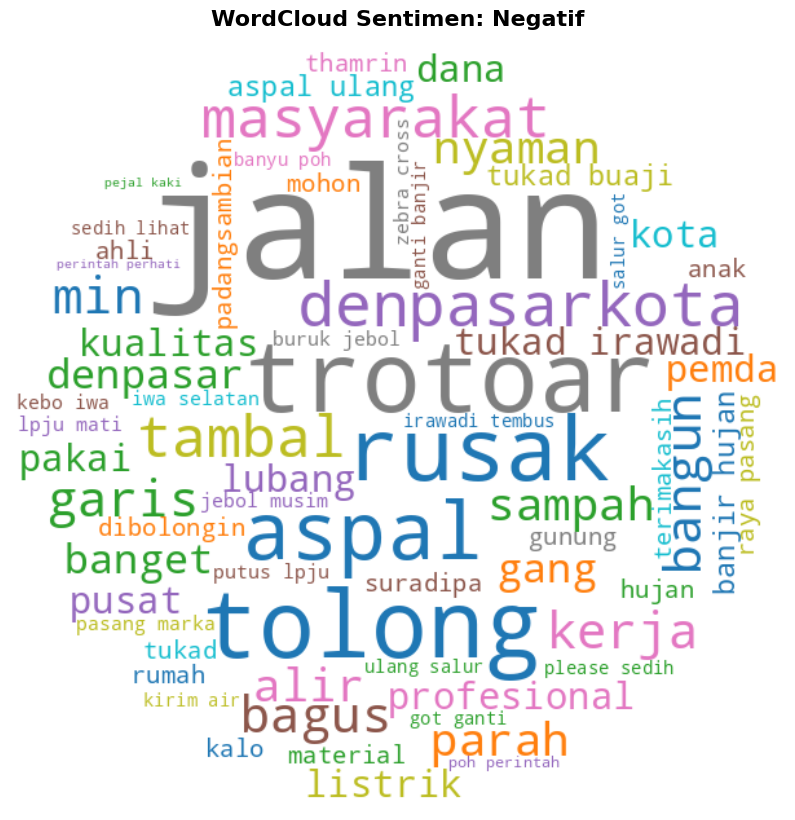

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def create_circle_mask(diameter=600):
    """Membuat mask berbentuk lingkaran dengan ukuran diameter tertentu."""
    x, y = np.ogrid[:diameter, :diameter]
    center = diameter // 2
    radius = diameter // 2
    mask = (x - center)**2 + (y - center)**2 > radius**2
    mask = 255 * mask.astype(int)
    return mask

def generate_wordcloud(text, title):
    circle_mask = create_circle_mask(600)

    wordcloud = WordCloud(
        width=200, height=200,
        background_color='white',
        colormap='tab10',
        max_words=100,
        prefer_horizontal=0.9,
        min_font_size=10,
        max_font_size=120,
        random_state=42,
        mask=circle_mask
    ).generate(text)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout(pad=0)
    plt.show()

# WordCloud semua komentar (umum)
all_text = ' '.join(df['stopword_str'])
generate_wordcloud(all_text, "WordCloud Umum – Semua Komentar")

# WordCloud per sentimen (positif, negatif, netral)
for label in df['sentimen'].unique():
    sentimen_text = ' '.join(df[df['sentimen'] == label]['stopword_str'])
    generate_wordcloud(sentimen_text, f"WordCloud Sentimen: {label.capitalize()}")

/tmp/ipython-input-16-536105647.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')


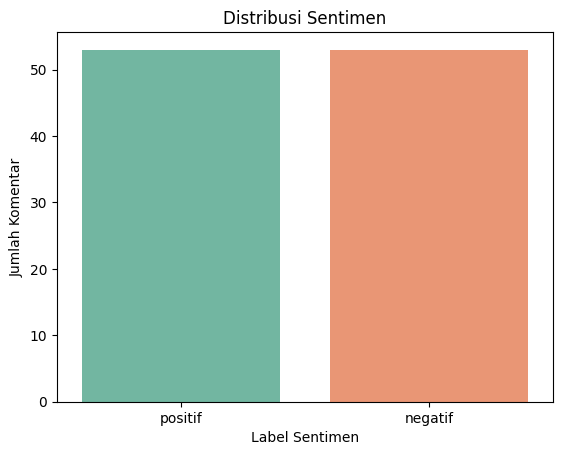

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sentimen_counts = df['sentimen'].value_counts()

sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')
plt.title("Distribusi Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xlabel("Label Sentimen")
plt.show()

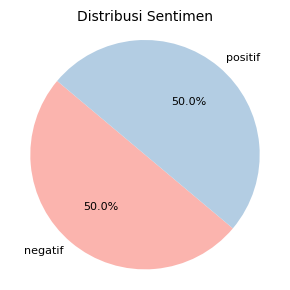

In [ ]:
sentimen_count = Counter(y_pred)

label_ids = list(sentimen_count.keys())
jumlah = list(sentimen_count.values())

label_names = le.inverse_transform(label_ids)
colors = ['lightcoral', 'gold', 'mediumseagreen']

plt.figure(figsize=(3, 3))
plt.pie(
    jumlah,
    labels=label_names,
    colors=plt.cm.Pastel1.colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    radius=0.8
)
plt.title("Distribusi Sentimen", fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
emosi_lexicon = {
    "senang": [
        "terima kasih", "suksma", "mantap", "bagus", "baik", "puas", "makasih",
        "moga lancar", "nggih", "selamat", "hebat", "nyaman", "ideal", "makmur", "unggul"
    ],
    "sedih": [
        "sedih", "kecewa", "miris", "nyeri", "parah", "sayang", "capek", "buruk", "rusak",
        "banjir", "lubang", "bobol", "buntu", "kotor", "bahaya", "gelap", "begajulan", "tidak rata",
        "tidak nyaman", "tidak fungsi", "tidak profesional", "tidak bermanfaat", "kurang"
    ],
    "marah": [
        "ngapain", "aneh", "kenapa", "kok bisa", "gimana", "tidak tahu", "kenapa belum",
        "asal-asalan", "tidak sesuai", "salah", "tidak mempan", "komplain", "tidak adil", "jengkel"
    ],
    "optimis": [
        "optimis", "harap", "semoga", "astungkara", "yakin", "mudah-mudahan",
        "moga", "harap", "lanjut", "segera", "dalam tahap", "akan baik", "akan aspal",
        "akan diperbaiki", "masuk list", "masuk proyek", "teruskan", "ditindaklanjuti"
    ],
    "ragu-ragu": [
        "mungkin", "bingung", "gatau", "tidak tahu", "ragu", "entahlah", "kurang tahu",
        "belum pasti", "kayaknya", "seperti", "kalau", "kira-kira"
    ],
    "kritis": [
        "cek", "tolong", "kapan", "kenapa", "harap", "koordinasi", "perlu perhatian",
        "tolong atensi", "apakah", "harus", "bagaimana", "seharusnya", "kenapa tidak", "mohon"
    ]
}

def deteksi_emosi(teks):
    teks = str(teks).lower()
    for emosi, kata_kunci in emosi_lexicon.items():
        for kata in kata_kunci:
            if kata in teks:
                return emosi
    return "biasa saja"

df['emosi'] = df['stopword_str'].apply(deteksi_emosi)

df[['stopword_str', 'emosi']].head(10)

,stopword_str,emosi
0,moga jalan denpasar bagus banjir,senang
1,denpasarkota subak dung kering mohon alir sung...,senang
2,denpasarkota mohon tindak karna cuman sih si m...,sedih
3,denpasarkota tunggu min,biasa saja
4,yaa tau dana darimana pulau roti koordinasi de...,kritis
5,terimakasih kakak mininfo keluh kritik saran k...,senang
6,tolong jalan raya pasang marka garis jalan zeb...,kritis
7,jalan suradipa peguyangan denpasar utara parah...,sedih
8,denpasarkota tunggu min,biasa saja
9,denpasarkota subak dung kering mohon alir sung...,senang


In [ ]:
print("Jumlah data emosi:")
print(df['emosi'].value_counts())

Jumlah data emosi:
emosi
biasa saja    41
senang        31
sedih         25
kritis         7
marah          2
Name: count, dtype: int64


In [ ]:
def preprocess_input(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()

    for key, value in norm.items():
        text = text.replace(key, value)

    text = stop_remover.remove(text)
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def deteksi_emosi(teks):
    teks = str(teks).lower()
    for emosi, kata_kunci in emosi_lexicon.items():
        for kata in kata_kunci:
            if kata in teks:
                return emosi
    return "biasa saja"

def predict_sentiment(text):
    cleaned_text = preprocess_input(text)

    tfidf_vector = vectorizer.transform([cleaned_text])

    prediction = model.predict(tfidf_vector)

    prediction_label = le.inverse_transform(prediction)[0]

    emosi = deteksi_emosi(text)

    return prediction_label, emosi

In [ ]:
input_text = "Denpasar semakin bersih dan tertata."
hasil_sentimen, hasil_emosi = predict_sentiment(input_text)

print("Teks:", input_text)
print("Prediksi Sentimen:", hasil_sentimen)
print("Prediksi Emosi:", hasil_emosi)

Teks: Denpasar semakin bersih dan tertata.
Prediksi Sentimen: positif
Prediksi Emosi: biasa saja
